<a href="https://colab.research.google.com/github/HofstraDoboli/TextMining_F22/blob/main/movie_clustering_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics 

dir_file = os.getcwd() # returns path to current directory
files_dir = os.listdir(dir_file)  # list of files in current directory

csv_files = [f for f in files_dir if f.endswith('csv')]
movie_file = csv_files[0]

fid = open(movie_file)
movie_df = pd.read_csv(movie_file)
print(movie_df.columns)  # the columns
print(movie_df.shape)

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')
(34886, 8)


In [ ]:
# extract only the top 20 topics
from collections import Counter 

genres_dict = Counter(movie_df['Genre'])  
choose_genres = ['western', 'thriller']
nr_genres = len(choose_genres)
most_common_genres = [t[0] for t in genres_dict.items() if t[0] in choose_genres]
#most_common_genres = [t[0] for t in genres_dict.most_common(3) if t[0] != 'unknown']
print(most_common_genres)
print(genres_dict.most_common(20))

# filter movies based non genres
nr_genres = 2
index_movies_top_20 = movie_df['Genre'].isin(most_common_genres)   # returns a bool index
print(index_movies_top_20.shape)
selected_movies = movie_df[index_movies_top_20]
print(selected_movies.shape)

['western', 'thriller']
[('unknown', 6083), ('drama', 5964), ('comedy', 4379), ('horror', 1167), ('action', 1098), ('thriller', 966), ('romance', 923), ('western', 865), ('crime', 568), ('adventure', 526), ('musical', 467), ('crime drama', 464), ('romantic comedy', 461), ('science fiction', 418), ('film noir', 345), ('mystery', 310), ('war', 273), ('animation', 264), ('comedy, drama', 236), ('sci-fi', 221)]
(34886,)
(1831, 8)


In [ ]:
vect = CountVectorizer(stop_words = 'english',lowercase = True, max_features = 1000) # ? why 50 

counter = vect.fit_transform(selected_movies['Plot'])
transf  = TfidfTransformer(norm = 'l2', sublinear_tf = True) 
# TfidfTransformer takes the CountVectorizer output and computes the tf-idf
tf_idf = transf.fit_transform(counter)  # matrix representation of each movie as a tf-idf vector

print(len(vect.get_feature_names()))

1000


In [ ]:
k_clusters = 2
model = MiniBatchKMeans(n_clusters=k_clusters, init='k-means++', max_iter=100, batch_size=5000, 
                        n_init = 10, verbose = 0)
model.fit(tf_idf)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(tf_idf, model.labels_, metric = "cosine"))


Silhouette Coefficient: 0.022


In [ ]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]  # sort and reverse
terms = vect.get_feature_names()

for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:  # print first ten terms from the cluster
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 police
 house
 finds
 wife
 man
 life
 later
 murder
 home
 tells
Cluster 1:
 town
 men
 gang
 ranch
 sheriff
 war
 man
 john
 cattle
 killed


In [ ]:
# compute homogeneity with genre labels

# get genre for the selected movies
genre = selected_movies.Genre.copy()
genre = pd.Categorical(genre)
# labels_genre = genre.codes
# print(type(labels_genre), labels_genre.shape)

print("Homogeneity: %0.3f"  % metrics.homogeneity_score(genre, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(genre, model.labels_))
print("V-measure: %0.3f"    % metrics.v_measure_score(genre, model.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(genre, model.labels_))

Homogeneity: 0.637
Completeness: 0.635
V-measure: 0.636
Adjusted Rand-Index: 0.727


In [ ]:
# compute purity 
# in each cluster - find # of dramas/ # commedies 
# choose the max in each cluster = purity per cluster
# sum purity in each cluster/# number of movies
import numpy as np

#print(genre.shape, index_cluster1.shape, index_cluster2.shape)
purity = np.zeros((k_clusters,1))
for c in range(k_clusters):
    # extract labeks of each genre and count them
    index_cluster = model.labels_ == c;
    count_genre = Counter(genre[index_cluster])
    print(c, count_genre)
    purity[c] = max(count_genre.values())

total_purity = np.sum(purity)/len(genre)
print(total_purity)

0 Counter({'thriller': 861, 'western': 30})
1 Counter({'western': 835, 'thriller': 105})
0.9262697979246314


In [ ]:
# check some data points

# find index for drama movies
index_drama =  selected_movies['Genre'].isin(['thriller'])
index_comedy = selected_movies['Genre'].isin(['western'])

print(sorted(Counter(model.labels_[index_drama]).items(),key = 
             lambda kv:(kv[1], kv[0]), reverse =True))
print(sorted(Counter(model.labels_[index_comedy]).items(),key = 
             lambda kv:(kv[1], kv[0]), reverse =True))


[(0, 861), (1, 105)]
[(1, 835), (0, 30)]


In [ ]:
model.labels_[index_drama]

array([25, 12, 28, ..., 20,  6,  6], dtype=int32)

In [ ]:
# project Tfidf model onto singular value decomposition - LSI transform and then do clustering
from sklearn.decomposition import TruncatedSVD

dim = 100
svd = TruncatedSVD(n_components=dim, n_iter = 10)

lsi = svd.fit_transform(tf_idf)
print(lsi.shape)

(1831, 100)


In [ ]:
# check singular values

explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))

print(svd.singular_values_[:min(dim,20)])  

Sum of explained variance ratio: 32%
[11.37668659  4.99886657  3.89349417  3.31033615  3.19558691  3.09193352
  3.00330526  2.83227131  2.81027512  2.73065076  2.70626273  2.66013061
  2.65617477  2.62511866  2.59663756  2.59053353  2.57336299  2.54722217
  2.51866679  2.49960796]


In [ ]:
k_clusters = 2
#model_lsi = MiniBatchKMeans(n_clusters=k_clusters, init='k-means++', max_iter=200, batch_size=5000, 
#                       n_init = 10)
model_lsi = KMeans(n_clusters=k_clusters, init='k-means++', max_iter=200,  
                        n_init = 50)
model_lsi.fit(lsi)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(tf_idf, model_lsi.labels_, metric = "cosine"))


Silhouette Coefficient: 0.018


In [ ]:
# compute homogeneity with genre labels

# get genre for the selected movies
genre = selected_movies.Genre.copy()
genre = pd.Categorical(genre)
# labels_genre = genre.codes
# print(type(labels_genre), labels_genre.shape)

print("Homogeneity: %0.3f"  % metrics.homogeneity_score(genre, model_lsi.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(genre, model_lsi.labels_))
print("V-measure: %0.3f"    % metrics.v_measure_score(genre, model_lsi.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(genre, model_lsi.labels_))

Homogeneity: 0.418
Completeness: 0.431
V-measure: 0.424
Adjusted Rand-Index: 0.455


In [ ]:
# print top topic indices per cluster
print("Top top words per cluster:")
terms = vect.get_feature_names()

# find movies in each cluster, sum up their counts and print the top words
for k in range(k_clusters):
    index_movies_k = model_lsi.labels_ == k
    count_terms_k = sum(counter[index_movies_k,:])   # sum per columns 
    order_terms = count_terms_k.toarray().argsort()[:,::-1].ravel()  # convert to a 1D array
    print('Cluster', k)
    
    for t in order_terms[:10]:
        print('\t', terms[t], count_terms_k[0,t])

#order_centroids = model_lda.cluster_centers_.argsort()[:, ::-1]  # sort and reverse
#for i in range(k_clusters):
#print("Cluster %d:" % i),
#    for ind in order_centroids[i, :5]:  # print first ten terms from the cluster
#.   print(ind, model_lda.cluster_centers_[i,ind])

Top top words per cluster:
Cluster 0
	 police 967
	 tells 779
	 house 779
	 man 771
	 later 670
	 finds 667
	 home 625
	 car 608
	 father 585
	 wife 552
Cluster 1
	 town 898
	 men 879
	 man 500
	 ranch 491
	 killed 476
	 gang 466
	 father 396
	 sheriff 391
	 gene 357
	 john 337


In [ ]:
# compute purity 
# in each cluster - find # of dramas/ # commedies 
# choose the max in each cluster = purity per cluster
# sum purity in each cluster/# number of movies
import numpy as np

purity = np.zeros((k_clusters,1))
for c in range(k_clusters):
    # extract labeks of each genre and count them
    index_cluster = model_lsi.labels_ == c;
    count_genre = Counter(genre[index_cluster])
    print(c, count_genre)
    purity[c] = max(count_genre.values())

total_purity = np.sum(purity)/len(genre)
print(total_purity)

0 Counter({'western': 835, 'thriller': 268})
1 Counter({'thriller': 698, 'western': 30})
0.8372474057891862


In [ ]:
# doesn't work
#plot clusters
#!pip install -U scikit-learn
#!pip install -U yellowbrick
#import sklearn.metrics._classification
#import yellowbrick
#from yellowbrick.text import TSNEVisualizer

In [ ]:
# plot clusters
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components = 2)
#print('explained variance')
pca.fit(tf_idf)
x2 = pca.transform(tf_idf)

In [ ]:
print(x2.shape)
# add labels
data_x2 = pd.DataFrame(x2, columns = ['x','y'])
data_x2['label'] = model.labels_
data_x2['orig_label'] = genre
data_x2.head()

(1831, 2)


,x,y,label,orig_label
0,0.209439,0.054299,1,western
1,0.226561,0.158017,1,western
2,0.128844,0.065188,1,western
3,0.086121,0.046000,1,western
4,0.253240,0.026334,1,western


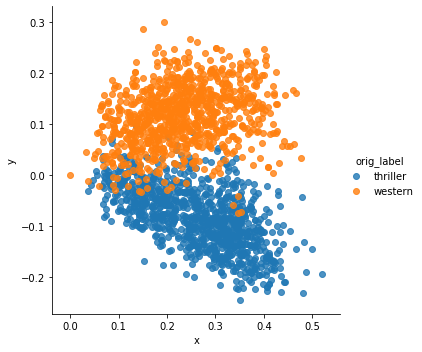

In [ ]:
sb.lmplot(data=data_x2, x='x', y='y', hue='orig_label',fit_reg=False, legend=True, legend_out=True) 

In [ ]:
# get terms in each cluster
# check some data points
import operator


# find index for drama movies
index_drama =  selected_movies['Genre'].isin(['crime'])
index_comedy = selected_movies['Genre'].isin(['comedy'])
index_unknown = selected_movies['Genre'].isin(['unknown'])

count_clusters_crime  =  Counter(model_lsi.labels_[index_drama])
count_clusters_comedy =  Counter(model_lsi.labels_[index_comedy])
count_clusters_unknown = Counter(model_lsi.labels_[index_unknown])

sort_crime = sorted(count_clusters_crime.items(), key =  lambda kv: kv[1], reverse =True)
sort_comedy = sorted(count_clusters_comedy.items(), key =  lambda kv: kv[1], reverse =True)
sort_unknown = sorted(count_clusters_unknown.items(), key =  lambda kv: kv[1], reverse =True)


print(sort_crime)
print(sort_comedy)
print(sort_unknown)


[(9, 283), (5, 95), (2, 75), (8, 68), (6, 21), (4, 15), (1, 5), (0, 5), (7, 1)]
[(9, 1689), (2, 819), (6, 696), (8, 402), (1, 214), (0, 211), (5, 168), (4, 105), (7, 73), (3, 2)]
[(0, 2097), (9, 1822), (8, 622), (2, 490), (7, 370), (3, 247), (1, 207), (6, 115), (5, 78), (4, 35)]


In [ ]:
# LDA with sklearn
from sklearn.decomposition import LatentDirichletAllocation

num_of_topics = 20
lda_transf = LatentDirichletAllocation(
            n_components = num_of_topics, max_iter= 10, 
            learning_method = 'online', batch_size = 1000)   # 'online' - faster, uses subset of data
lda = lda_transf.fit_transform(counter)
print(lda.shape)
print(lda_transf.components_.shape)

(1831, 20)
(20, 1000)


In [ ]:
# get distribution of each document over the 10 topics
print(lda[100,:])


[0.00147089 0.00147095 0.00147094 0.00147108 0.2024499  0.00147083
 0.78578252 0.00147087 0.00147105 0.00147096]


In [ ]:
# get largest distribution of words over topics
feature_names = vect.get_feature_names()  # feature_names - array of 8955 components
for topic_idx, topic in enumerate(lda_transf.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-10 - 1:-1]:
            words.append(feature_names[i])
        print(words)

Topic 0:
['helen', 'dr', 'kid', 'clay', 'anna', 'john', 'william', 'ward', 'grant', 'young']
Topic 1:
['lisa', 'money', 'steve', 'house', 'love', 'police', 'tries', 'finds', 'friend', 'body']
Topic 2:
['jason', 'kevin', 'charles', 'tom', 'rachel', 'harris', 'kansas', 'hunter', 'horse', 'ranch']
Topic 3:
['jeff', 'sara', 'frank', 'sarah', 'dylan', 'wyatt', 'jim', 'jonathan', 'money', 'train']
Topic 4:
['gene', 'gold', 'men', 'gang', 'ranch', 'posse', 'town', 'money', 'bank', 'escape']
Topic 5:
['joe', 'bob', 'cole', 'martha', 'jackson', 'jill', 'ruth', 'town', 'terry', 'men']
Topic 6:
['tom', 'john', 'johnny', 'mary', 'mrs', 'tex', 'boys', 'gang', 'town', 'claire']
Topic 7:
['ben', 'nick', 'matt', 'peter', 'alex', 'amy', 'husband', 'goes', 'men', 'tells']
Topic 8:
['police', 'house', 'man', 'tells', 'car', 'jack', 'later', 'finds', 'home', 'wife']
Topic 9:
['men', 'man', 'group', 'killed', 'train', 'kill', 'woman', 'war', 'town', 'kills']
Topic 10:
['henry', 'jim', 'jo', 'alice', 'gil',

In [ ]:
# get distribution of drama and comedy films over topics
import numpy as np

index_drama =  selected_movies['Genre'].isin(['crime'])
index_comedy = selected_movies['Genre'].isin(['comedy'])
index_other  = selected_movies['Genre'].isin(['unknown'])

print(lda[index_drama].mean(axis = 0))
print(lda[index_comedy].mean(axis = 0))
print(lda[index_other].mean(axis = 0))

[0.06133079 0.05351509 0.06795695 0.02151056 0.06192285 0.02959826
 0.01132539 0.0187393  0.02771013 0.02848709 0.14116545 0.00581557
 0.05984478 0.01383142 0.25049446 0.0209323  0.01218169 0.01394667
 0.02111916 0.07857209]
[0.13440892 0.08764203 0.20724195 0.03307539 0.05983403 0.03223683
 0.008736   0.01544125 0.03033841 0.02672954 0.05361401 0.00571262
 0.05818815 0.01430997 0.04108809 0.02031248 0.01164555 0.02653082
 0.03573008 0.09718386]
[0.07991179 0.16688353 0.12245319 0.21360944 0.04537491 0.03224628
 0.00693909 0.00689734 0.00954376 0.02394355 0.03247384 0.00893626
 0.03133146 0.00655922 0.06957701 0.00523063 0.01204469 0.02401892
 0.08508343 0.01694167]


In [ ]:
# cluster based on LDA
k_clusters = 2
model_lda = MiniBatchKMeans(n_clusters=k_clusters, init='k-means++', max_iter=200, batch_size=1000, 
                        n_init = 10)
model_lda.fit(lda)

MiniBatchKMeans(batch_size=1000, max_iter=200, n_clusters=2, n_init=10)

In [ ]:
# compute homogeneity with genre labels

# get genre for the selected movies
genre = selected_movies.Genre.copy()
genre = pd.Categorical(genre)
# labels_genre = genre.codes
# print(type(labels_genre), labels_genre.shape)

print("Homogeneity: %0.3f"  % metrics.homogeneity_score(genre, model_lda.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(genre, model_lda.labels_))
print("V-measure: %0.3f"    % metrics.v_measure_score(genre, model_lda.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(genre, model_lda.labels_))

Homogeneity: 0.318
Completeness: 0.348
V-measure: 0.332
Adjusted Rand-Index: 0.302


In [ ]:
# compute purity 
# in each cluster - find # of dramas/ # commedies 
# choose the max in each cluster = purity per cluster
# sum purity in each cluster/# number of movies
import numpy as np

#print(genre.shape, index_cluster1.shape, index_cluster2.shape)
purity = np.zeros((k_clusters,1))
for c in range(k_clusters):
    # extract labeks of each genre and count them
    index_cluster = model_lda.labels_ == c;
    count_genre = Counter(genre[index_cluster])
    print(c, count_genre)
    purity[c] = max(count_genre.values())

total_purity = np.sum(purity)/len(genre)
print(total_purity)

0 Counter({'western': 843, 'thriller': 390})
1 Counter({'thriller': 576, 'western': 22})
0.774986346258875


In [ ]:
# print top topic indices per cluster
print("Top topic indices per cluster:")
order_centroids = model_lda.cluster_centers_.argsort()[:, ::-1]  # sort and reverse

for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:  # print first ten terms from the cluster
        print(ind, model_lda.cluster_centers_[i,ind])
  

Top topic indices per cluster:
Cluster 0:
9 0.4221994235929714
10 0.06663026725569314
19 0.06101264107765858
12 0.055693570566070785
4 0.046813705108514424
Cluster 1:
14 0.3118490779208042
10 0.135482348368683
19 0.06760445219950605
0 0.06056345843602185
2 0.05995493746572067
Cluster 2:
3 0.47380302333471713
1 0.1590969321525035
14 0.07027183126831037
2 0.06763853984228954
0 0.05233643964613286
Cluster 3:
5 0.3354123265694002
0 0.09532841300036224
12 0.07923350212374386
2 0.06204251082006643
1 0.05365243380523477
Cluster 4:
4 0.4501876430265231
2 0.07024905299808681
17 0.05276770277018553
0 0.045419732905804845
9 0.043156412951773276
Cluster 5:
0 0.4601834014408931
2 0.0808436134342607
1 0.061290924615599277
19 0.0554040504742478
12 0.040660721842034085
Cluster 6:
2 0.5110900924263934
0 0.0566580310484818
1 0.05625868690453718
19 0.049852684176594796
4 0.03372263080546655
Cluster 7:
1 0.4627882932537935
3 0.08866726514452904
2 0.07096231596833118
0 0.06783987672222201
19 0.043560380019

In [ ]:
# find the closest movie to a another movie using tf-idf, lda and lsi embeddings

def similar_movie(movie_id, all_embed):
    
    nr_movies   = all_embed.shape[0]  # number of rows = nr of movies
    movie_embed = all_embed[movie_id,:]
    
    
    dist = all_embed.dot(movie_embed.transpose())
    dist[movie_id] = 0;
    print('Most similar movie:', dist.max(), dist.argmax())
    
    return dist.argmax()

def print_movie(movie_id, all_movies):
    index_title = selected_movies.columns.get_loc('Title')
    index_plot  = selected_movies.columns.get_loc('Plot')
    print(all_movies.iloc[movie_id, index_title],'\n')
    print('\t', all_movies.iloc[movie_id,index_plot])
    
movie_id = 7595 # 17663 # Ninja terminator 8244 # Indiana Jones # 7595 - Star wars # 2000
print('Original movie')
print_movie(movie_id, selected_movies)
print('\ntf-idf most similar')
similar_tf_idf = similar_movie(movie_id,tf_idf)
print_movie(similar_tf_idf, selected_movies)

print('\nlsi most similar')
similar_lsi    = similar_movie(movie_id,lsi)
print_movie(similar_lsi, selected_movies)

print('\nlda most similar')
similar_lda    = similar_movie(movie_id, lda)
print_movie(similar_lda, selected_movies)


Original movie
Star Wars Episode IV: A New Hope (aka Star Wars) 

	 The galaxy is in the midst of a civil war. Spies for the Rebel Alliance have stolen plans to the Galactic Empire's Death Star, a space station capable of destroying an entire planet. Rebel leader Princess Leia has the plans, but her ship is captured by Imperial forces under the command of the ruthless Sith Lord, Darth Vader. Before she is captured, Leia hides the plans in the memory of an astromech droid, R2-D2, along with a holographic recording. R2-D2 flees to the desert planet Tatooine with C-3PO, a protocol droid.
The droids are captured by Jawa traders, who sell them to moisture farmers Owen and Beru Lars, and their nephew Luke Skywalker. While cleaning R2-D2, Luke accidentally triggers part of Leia's message, in which she requests help from Obi-Wan Kenobi. The next morning, Luke finds R2-D2 missing, and meets Ben Kenobi, an old hermit who lives in the hills, and reveals himself to be Obi-Wan. Obi-Wan tells Luke o

print(selected_movies(100))

In [ ]:
# find the index of the star war movie
titles = selected_movies['Title']
index_found = [i for i,t in enumerate(titles.str.find('Star W')) if t != -1]
print(index_found)
print(selected_movies.iloc[index_found[0]])

[1231, 1948, 1949, 2524, 4915, 5159, 6985, 7663, 9735, 13494, 14103, 14176, 14740]
Release Year                                                     1933
Title                                               King of the Arena
Origin/Ethnicity                                             American
Director                                                   Alan James
Cast                                       Ken Maynard, Lucile Browne
Genre                                                         western
Wiki Page             https://en.wikipedia.org/wiki/King_of_the_Arena
Plot                A former circus performer, Ken Kenton becomes ...
Name: 1538, dtype: object


In [ ]:
# show movies in the same cluster